# Clasificador de Vinos con KNN
Entrena un modelo de K-Vecinos más Cercanos (KNN) para predecir la calidad de un vino tinto a partir de sus características químicas. ¿Podría una IA ayudarte a elegir un vino digno de sommelier?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import randint
# To save models
import json
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ini = pd.read_csv('../data/raw/winequality-red.csv', sep=';')
df_ini.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df_ini.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df= df_ini.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


> Al eliminar duplicados me quedo con 1359 entradas cuando teniamos 1599.

## Variables númericas

> Creo mapa de calor de > de 0,40 para ver las más correlacionadas y eliminar columnas.

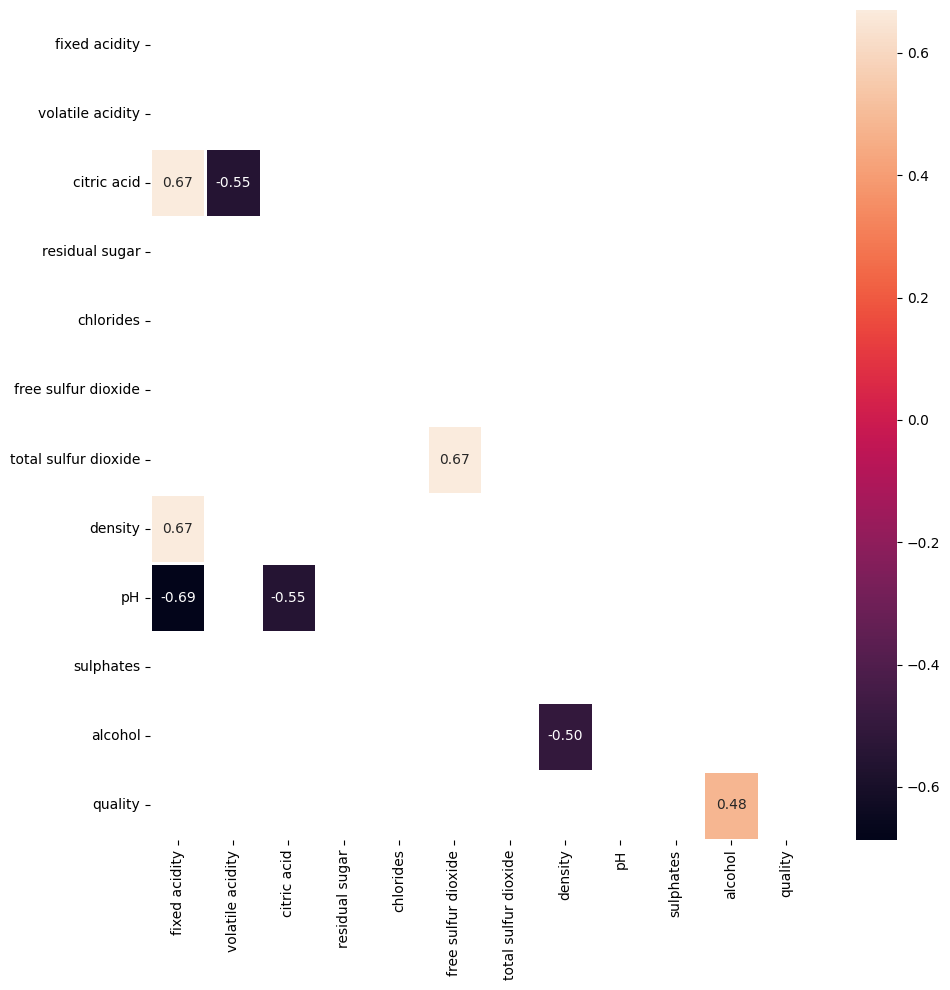

In [5]:
corr = df.corr()
high_correlation = corr[corr.abs() > 0.40]
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axis = plt.subplots(figsize=(10,10))
sns.heatmap(high_correlation, annot=True, mask=mask, linewidths=1, fmt=".2f")

plt.tight_layout()
plt.show()

> Elimino las variables que estan más correlacionadas entre sí.

In [6]:
columns_drop = ['citric acid', 'density', 'pH', 'free sulfur dioxide']
                
df.drop(columns_drop, axis=1, inplace=True)

df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.70,1.9,0.076,34.0,0.56,9.4,5
1,7.8,0.88,2.6,0.098,67.0,0.68,9.8,5
2,7.8,0.76,2.3,0.092,54.0,0.65,9.8,5
3,11.2,0.28,1.9,0.075,60.0,0.58,9.8,6
5,7.4,0.66,1.8,0.075,40.0,0.56,9.4,5


> Miro que datos tengo en la columna target (quality) para poderlo segregar en 3 categorías tal como indica el ejercicio. Donde sea:
> - 0= Baja calidad
> - 1 = Calidad media
> - 2 = Alta calidad

In [7]:
df.value_counts('quality')

quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64

In [8]:
# Defino la nueva columna
df['quality_segment'] = -1  

# Calidad Baja: 3 y 4 -> 0
df.loc[df['quality'].isin([3, 4]), 'quality_segment'] = 0

# Calidad Media: 5 y 6 -> 1
df.loc[df['quality'].isin([5, 6]), 'quality_segment'] = 1

# Calidad Alta: 7 y 8 -> 2
df.loc[df['quality'].isin([7, 8]), 'quality_segment'] = 2

# Elimino la columna 'quality' original
df = df.drop(columns=['quality'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   residual sugar        1359 non-null   float64
 3   chlorides             1359 non-null   float64
 4   total sulfur dioxide  1359 non-null   float64
 5   sulphates             1359 non-null   float64
 6   alcohol               1359 non-null   float64
 7   quality_segment       1359 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 95.6 KB


## Split

In [10]:
X = df.drop('quality_segment', axis=1)
y = df['quality_segment']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

## Scaling

In [11]:
norm_scaler = StandardScaler()  

num_variables = ['fixed acidity', 'volatile acidity', 'residual sugar','chlorides','total sulfur dioxide', 
                'sulphates','alcohol']

norm_train = norm_scaler.fit_transform(X_train[num_variables])
norm_test = norm_scaler.transform(X_test[num_variables])


## Modelo KNN Clasificación

In [12]:
# Modelo
model = KNeighborsClassifier(n_neighbors=5)

# Entrenamiento
model.fit(norm_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [13]:
# Predicción
y_pred_test = model.predict(norm_test)
y_pred_train = model.predict(norm_train)


In [14]:
#accuracy_score
accuracy = {'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Accuracy Train': accuracy_score(y_train, y_pred_train)}
accuracy

{'Accuracy Test': 0.8419117647058824, 'Accuracy Train': 0.8721251149954001}

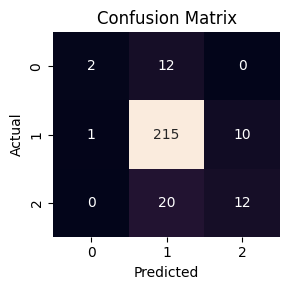

In [15]:
#confusion_matrix
confusionm = confusion_matrix(y_test, y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_confusionm = pd.DataFrame(confusionm)

plt.figure(figsize=(3, 3))
sns.heatmap(df_confusionm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


In [16]:
#classification_report
clas_repor = classification_report(y_test, y_pred_test, output_dict=True)
df_clas_repor =pd.DataFrame(clas_repor).T
df_clas_repor

,precision,recall,f1-score,support
0,0.666667,0.142857,0.235294,14.000000
1,0.870445,0.951327,0.909091,226.000000
2,0.545455,0.375000,0.444444,32.000000
accuracy,0.841912,0.841912,0.841912,0.841912
macro avg,0.694189,0.489728,0.529610,272.000000
weighted avg,0.821723,0.841912,0.819746,272.000000


## Observación del rendimiento.
> - La precisión general con Accuaracy del 84.19% en test y 87.21% en train es bastante buena.
> - En Classification_report, vemos que la clase uno tiene un buen resultado entre el recall y el f1-Score. por lo que nos indica que los resultados son fiables. En la clase 0 vemos un problema ya que tiene el Recall demasiado bajo y nos da a entender que esa clase está siendo tomada como otra posiblemente. No está identificandola bien. También sucede con la clase 2.
> - En Matrix de confusión, de la clase 0 solo 2 fueron clasificadas correctamente, Las otras 12  fueron predichas como clase 1, confirmamos con esto los datos obtenidos en Classification_report. Con la clase 2 sudece lo mismo. solo 12 de 32 fueron correctas el resto la identifico como clase 1 también.

Tendremos que hiperparametrizar el modelo probando otros 'n_neighbors' para conseguir mejores resultados.

### Hiperparametrización

In [17]:
# Creo una lista de valores de k, del 1 al 20.
k_values = list(range(1, 21))

# Almacenaremos en estas listas la precisión de prueba y de entrenamiento para cada k.
test_accuracies = []
train_accuracies = []

# Con el bucle probaré los diferentes valores de k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(norm_train, y_train)

    y_pred_test_k = knn_model.predict(norm_test)
    y_pred_train_k = knn_model.predict(norm_train)

    test_acc = accuracy_score(y_test, y_pred_test_k)
    train_acc = accuracy_score(y_train, y_pred_train_k)

    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

test_accuracies   


[0.7683823529411765,
 0.8198529411764706,
 0.8198529411764706,
 0.8345588235294118,
 0.8419117647058824,
 0.8455882352941176,
 0.8308823529411765,
 0.8382352941176471,
 0.8308823529411765,
 0.8308823529411765,
 0.8345588235294118,
 0.8308823529411765,
 0.8382352941176471,
 0.8382352941176471,
 0.8272058823529411,
 0.8308823529411765,
 0.8235294117647058,
 0.8308823529411765,
 0.8308823529411765,
 0.8345588235294118]

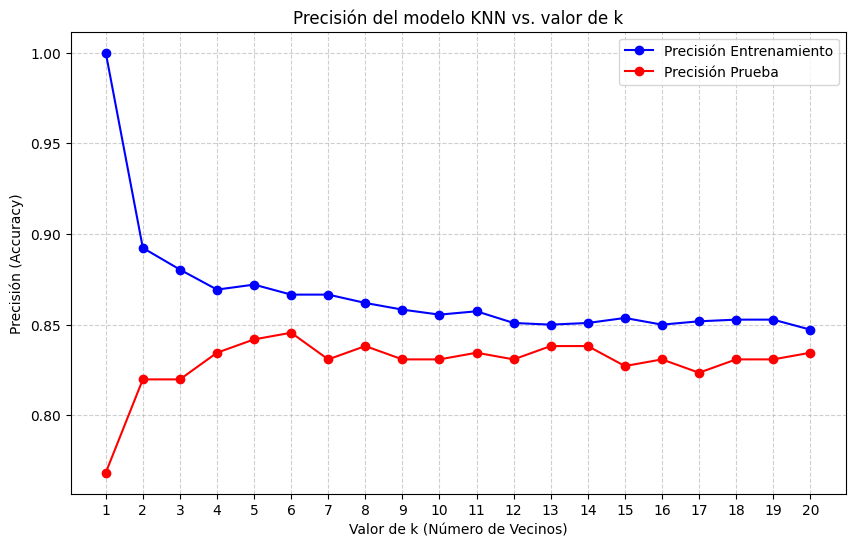

In [18]:
# Genero la Gráfica Accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Precisión Entrenamiento', marker='o', color='blue')
plt.plot(k_values, test_accuracies, label='Precisión Prueba', marker='o', color='red')


plt.title('Precisión del modelo KNN vs. valor de k')
plt.xlabel('Valor de k (Número de Vecinos)')
plt.ylabel('Precisión (Accuracy)')
plt.xticks(k_values) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


## Observaciones:
> A simple vista podríamos decir que el K=6 es el que mejor valor nos podrá dar ya que es de los mas altos en precisión y que menos diferencia tiene entre test y train.
Vamos a buscar a continuación el mejor K a ver si sale el mismo que se observa en la gráfica.

In [19]:
# Encontrar el mejor k
best_k_index = np.argmax(test_accuracies)
best_k = k_values[best_k_index]
best_accuracy = test_accuracies[best_k_index]

f"El mejor valor de k basado en la precisión de prueba es: {best_k} (Precisión: {best_accuracy:.4f})"

'El mejor valor de k basado en la precisión de prueba es: 6 (Precisión: 0.8456)'

## Si ahora hacemos las métricas del modelo con 'n_neighbors'=6 e hiperparametrizando tendríamos que obtener mejor resultados. Vamos a verlo:

In [20]:
hiper_params = {'n_neighbors': [6], 
                'algorithm':['auto','ball_tree', 'kd_tree', 'brute'],
                'weights': ['uniform', 'distance'],
                'p': [1, 2], 
                'n_jobs':[2,3,4,5]}

random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=hiper_params,
                                   n_iter=50,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(norm_train, y_train)
random_search.best_params_


{'weights': 'distance',
 'p': 2,
 'n_neighbors': 6,
 'n_jobs': 2,
 'algorithm': 'auto'}

In [21]:
random_search.best_score_

np.float64(0.8316238954889442)

In [22]:
# Modelo
model2 = KNeighborsClassifier('weights': 'distance','p': 2,'n_neighbors': 6,'n_jobs': 2,'algorithm': 'auto')

# Entrenamiento
model2.fit(norm_train, y_train)

SyntaxError: invalid syntax (1032593196.py, line 2)

In [ ]:
# Predicción
y_pred_test = model2.predict(norm_test)
y_pred_train = model2.predict(norm_train)

In [ ]:
#accuracy_score
accuracy = {'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Accuracy Train': accuracy_score(y_train, y_pred_train)}
accuracy

{'Accuracy Test': 0.8455882352941176, 'Accuracy Train': 0.8666053357865685}

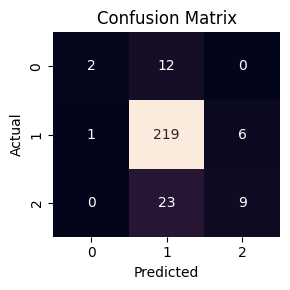

In [ ]:
#confusion_matrix
confusionm = confusion_matrix(y_test, y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_confusionm = pd.DataFrame(confusionm)

plt.figure(figsize=(3, 3))
sns.heatmap(df_confusionm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
#classification_report
clas_repor = classification_report(y_test, y_pred_test, output_dict=True)
df_clas_repor =pd.DataFrame(clas_repor).T
df_clas_repor

,precision,recall,f1-score,support
0,0.666667,0.142857,0.235294,14.000000
1,0.862205,0.969027,0.912500,226.000000
2,0.600000,0.281250,0.382979,32.000000
accuracy,0.845588,0.845588,0.845588,0.845588
macro avg,0.709624,0.464378,0.510258,272.000000
weighted avg,0.821293,0.845588,0.815347,272.000000


## Observaciones:
> Aunque hemos conseguido mejorar el acierto de la clase 2, sigue siento un % muy bajo de acierto.